In [ ]:
import kagglehub

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [4]:
#https://www.kaggle.com/datasets/whenamancodes/fraud-detection
path = kagglehub.dataset_download("whenamancodes/fraud-detection")
print("Path to dataset files:", path)
df = pd.read_csv(path + "\\creditcard.csv")
display(df.head())
print(df.shape)

100%|██████████| 66.0M/66.0M [00:13<00:00, 5.14MB/s]

Extracting files...


Path to dataset files: C:\Users\miaje\.cache\kagglehub\datasets\whenamancodes\fraud-detection\versions\1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)


##### About this dataset

* Contains transactions made by credit cards in September 2013 by European cardholders.
* Presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
* Highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
* Contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Due to confidentiality issues, the original features and more background information about the data cannot be provided. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
* The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
* Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
df_fraud = df[df.Class == 1]
df_legit = df[df.Class == 0]
print(f"{round((df_fraud.shape[0] / df.shape[0])*100, 2)}% fraudulent")

0.17% fraudulent


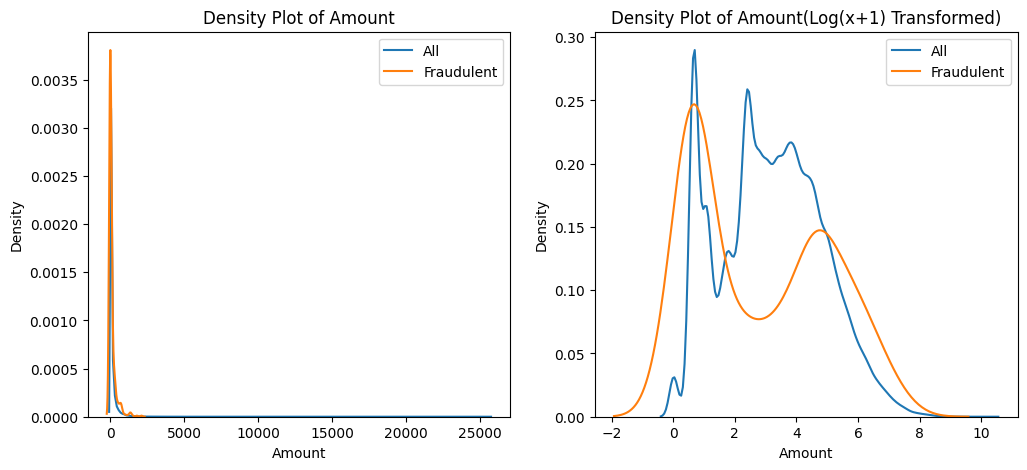

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df.Amount, label="All", ax=ax[0])
sns.kdeplot(df_fraud.Amount, label="Fraudulent", ax=ax[0])
ax[0].set_title("Density Plot of Amount")
ax[0].legend()

sns.kdeplot(np.log1p(df.Amount), label="All", ax=ax[1])
sns.kdeplot(np.log1p(df_fraud.Amount), label="Fraudulent", ax=ax[1])
ax[1].set_title("Density Plot of Amount(Log(x+1) Transformed)")
ax[1].legend()

plt.show()

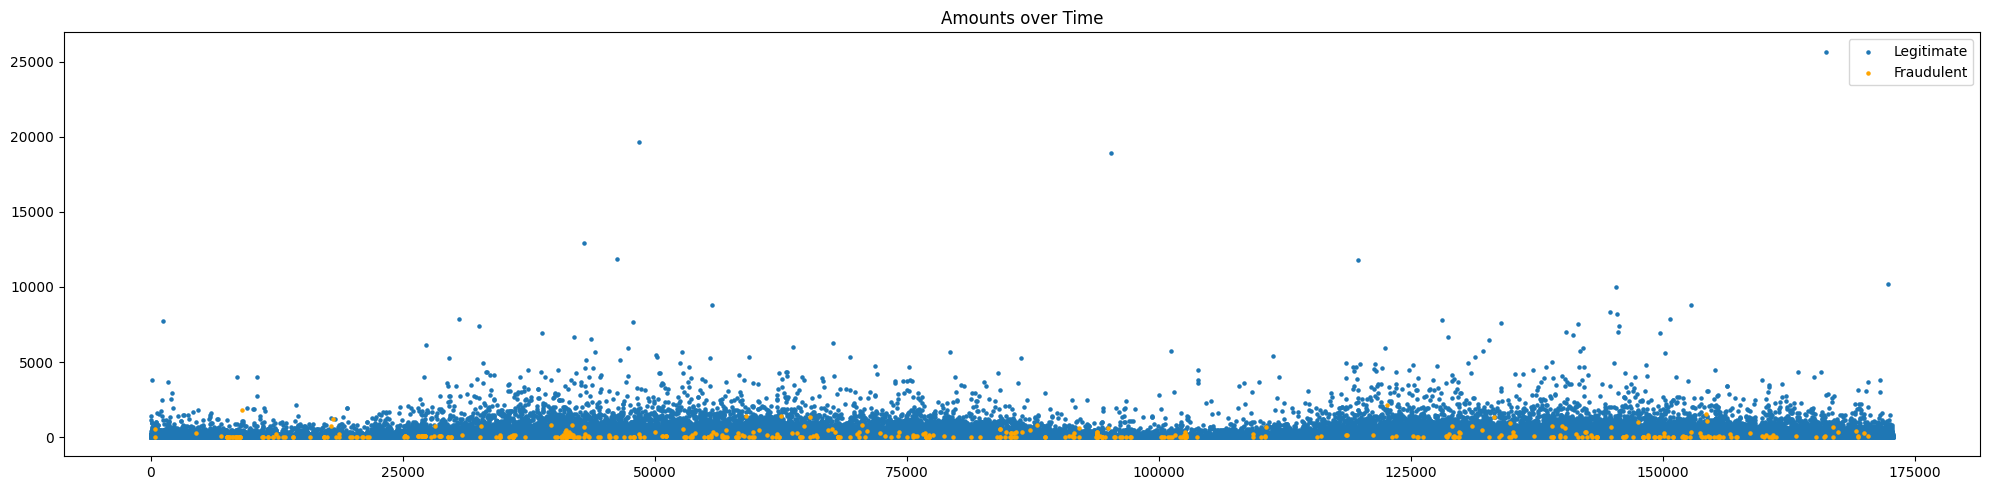

In [73]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.scatter(df_legit.Time, df_legit.Amount, s=5, label="Legitimate")
plt.scatter(df_fraud.Time, df_fraud.Amount, s=5, c="orange", label="Fraudulent")
plt.title("Amounts over Time")
plt.legend()
plt.tight_layout()
plt.show()

In [131]:
response = "Class"
y = df[response]
X = df.drop(columns=[response])

In [132]:
rs = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rs)

Isolation Forest

In [133]:
count_fraud = sum(y_train==1)
count_legit = sum(y_train==0)
contamination = count_fraud / len(y_train)
print(f"Fraudulent:\t {count_fraud}")
print(f"Legitimate:\t {count_legit}")
print(f"Contamination:\t {round(contamination*100, 2)}%")

Fraudulent:	 394
Legitimate:	 227451
Contamination:	 0.17%


In [134]:
model_if = IsolationForest(n_estimators=100, max_samples=len(X), contamination=contamination, random_state=rs, verbose=0)
model_if.fit(X_train)
print(model_if)

IsolationForest(contamination=0.001729245759178389, max_samples=284807,
                random_state=42)


In [138]:
scores_prediction = model_if.decision_function(X_test)
y_pred = model_if.predict(X_test)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

n_errors = (y_pred != y_test).sum()

print("Errors:", n_errors)

Errors: 131


In [142]:
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Legitimate", "Anomaly"]))

Accuracy Score:
0.9977002212000983

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
     Anomaly       0.34      0.37      0.35        98

    accuracy                           1.00     56962
   macro avg       0.67      0.68      0.68     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
auc = roc_auc_score((y_test == 1).astype(int), -scores_prediction)
print("ROC-AUC:", auc)

ROC-AUC: 0.9512515719568637


In [ ]:
threshold = np.percentile(scores_prediction, 0.5)
y_pred_custom = np.where(scores_prediction < threshold, 1, 0)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_custom, pos_label=1, average='binary')
print(f"Custom threshold metrics:\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


Custom threshold metrics:
Precision: 0.22, Recall: 0.65, F1: 0.33


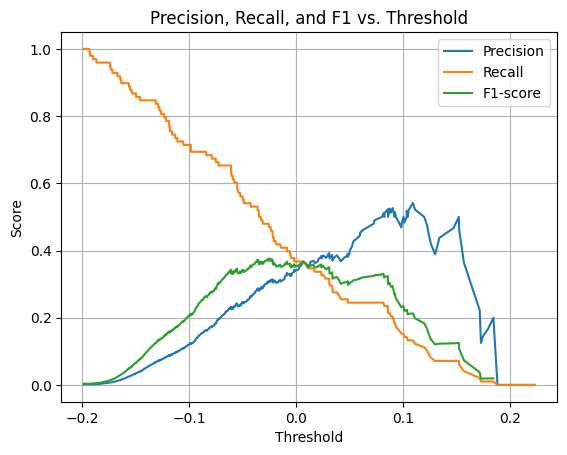

Best F1: 0.376 at threshold: 0.02558


In [ ]:

precisions, recalls, thresholds = precision_recall_curve(y_test, -scores_prediction)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]), label="F1-score")
plt.title("Precision, Recall, and F1 vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best F1: {f1_scores[best_idx]:.3f} at threshold: {-best_threshold:.5f}")

In [205]:
from sklearn.metrics import precision_recall_fscore_support

threshold = np.percentile(scores_prediction, 0.2)
y_pred_custom = np.where(scores_prediction < threshold, 1, 0)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_custom, pos_label=1, average='binary')
print(f"Custom threshold metrics:\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")


Custom threshold metrics:
Precision: 0.32, Recall: 0.38, F1: 0.35
